## This notebook calculates KBDI for the extent of input rasters

In [1]:
import xarray as xr
import numpy as np
from pathlib import Path

In [3]:
# ==================================================
# 1️⃣ Define directory paths for data input
# ==================================================
TEMP_DIR = Path("Data/2m Maximum Temperature ERA5")      # folder with daily Tmax NetCDFs (1 file per year)
PPT_DIR  = Path("Data/Total Precipitation ERA5") # folder with daily precipitation NetCDFs (1 file per year)
OUTPUT_DIR = Path("Outputs/KBDI_Output")
OUTPUT_DIR.mkdir(exist_ok=True)

START_YEAR = 2013
END_YEAR   = 2023


In [4]:
# ==================================================
# 2️⃣ KBDI formula (Crane/Alexander)
# ==================================================
def compute_kbdi_crane(kbdi_prev, temp_c, precip_mm, delta_t=1.0):
    """
    Pixel-wise KBDI calculation (daily)
    :param kbdi_prev: 2D DataArray of yesterday's KBDI
    :param temp_c: 2D DataArray of today's daily max temperature (°C)
    :param precip_mm: 2D DataArray of today's total precipitation (mm)
    :param delta_t: time step (1 day)
    :return: 2D DataArray of today's KBDI
    """
    # 1) KBDI reduced by rain (clipped at 0)
    q_si = kbdi_prev - precip_mm
    q_si = xr.where(q_si < 0, 0.0, q_si)

    # 2) Dryness term
    dryness_term = 0.968 * np.exp(0.0875 * temp_c + 1.5552) - 8.30

    # 3) Denominator to reduce drying when precipitation is high
    denom = 1.0 + 10.88 * np.exp(-0.001736 * precip_mm)

    # 4) Combine
    kbdi_today = q_si + ((203.2 - q_si) * dryness_term * delta_t / denom) * 1e-3

    # 5) Clip KBDI
    kbdi_today = xr.where(kbdi_today < 0, 0.0, kbdi_today)
    kbdi_today = xr.where(kbdi_today > 203.2, 203.2, kbdi_today)

    return kbdi_today


In [5]:
# ==================================================
# 3️⃣ Loop over years
# ==================================================
kbdi_prev = None  # pixel-wise previous day KBDI

for year in range(START_YEAR, END_YEAR + 1):
    print(f"Processing year {year}...")

    temp_file = TEMP_DIR / f"{year}.nc"
    ppt_file  = PPT_DIR  / f"{year}.nc"

    # Load datasets
    temp_ds = xr.open_dataset(temp_file)
    ppt_ds  = xr.open_dataset(ppt_file)

    # Extract variables
    tmax = temp_ds["t2m"] - 273.15  # Kelvin → Celsius
    ppt  = ppt_ds["tp"] * 1000.0    # meters → mm

    # Make sure dimensions align
    tmax, ppt = xr.align(tmax, ppt, join="inner")

    # Initialize kbdi_prev for first day
    if kbdi_prev is None:
        kbdi_prev = xr.zeros_like(tmax.isel(valid_time=0))

    kbdi_list = []

    # Loop over days
    for t in range(tmax.sizes["valid_time"]):
        temp_day = tmax.isel(valid_time=t)
        ppt_day  = ppt.isel(valid_time=t)

        # Compute pixel-wise KBDI
        kbdi_today = compute_kbdi_crane(kbdi_prev, temp_day, ppt_day)

        kbdi_list.append(kbdi_today)
        kbdi_prev = kbdi_today

    # Combine daily KBDI into a single DataArray
    kbdi_da = xr.concat(kbdi_list, dim="valid_time")
    kbdi_da = kbdi_da.assign_coords(valid_time=tmax.valid_time)

    # Convert to dataset
    kbdi_ds = kbdi_da.to_dataset(name="KBDI")
    kbdi_ds.attrs.update({
        "description": "Pixel-wise Keetch-Byram Drought Index (Crane/Alexander)",
        "units": "mm",
        "temperature": "daily max 2m temperature",
        "precipitation": "daily total precipitation"
    })

    # Save NetCDF
    out_file = OUTPUT_DIR / f"KBDI_Queensland_{year}.nc"
    kbdi_ds.to_netcdf(out_file)
    print(f"Saved {out_file}")

print("✅ All years processed successfully.")

Processing year 2013...
Saved Outputs/KBDI_Output/KBDI_Queensland_2013.nc
Processing year 2014...
Saved Outputs/KBDI_Output/KBDI_Queensland_2014.nc
Processing year 2015...
Saved Outputs/KBDI_Output/KBDI_Queensland_2015.nc
Processing year 2016...
Saved Outputs/KBDI_Output/KBDI_Queensland_2016.nc
Processing year 2017...
Saved Outputs/KBDI_Output/KBDI_Queensland_2017.nc
Processing year 2018...
Saved Outputs/KBDI_Output/KBDI_Queensland_2018.nc
Processing year 2019...
Saved Outputs/KBDI_Output/KBDI_Queensland_2019.nc
Processing year 2020...
Saved Outputs/KBDI_Output/KBDI_Queensland_2020.nc
Processing year 2021...
Saved Outputs/KBDI_Output/KBDI_Queensland_2021.nc
Processing year 2022...
Saved Outputs/KBDI_Output/KBDI_Queensland_2022.nc
Processing year 2023...
Saved Outputs/KBDI_Output/KBDI_Queensland_2023.nc
✅ All years processed successfully.


In [6]:
kbdi_ds = xr.open_dataset("Outputs/KBDI_Output/KBDI_Queensland_2013.nc")
kbdi = kbdi_ds["KBDI"]

print("KBDI min:", float(kbdi.min()))
print("KBDI max:", float(kbdi.max()))

KBDI min: 0.03423729166388512
KBDI max: 190.3494873046875


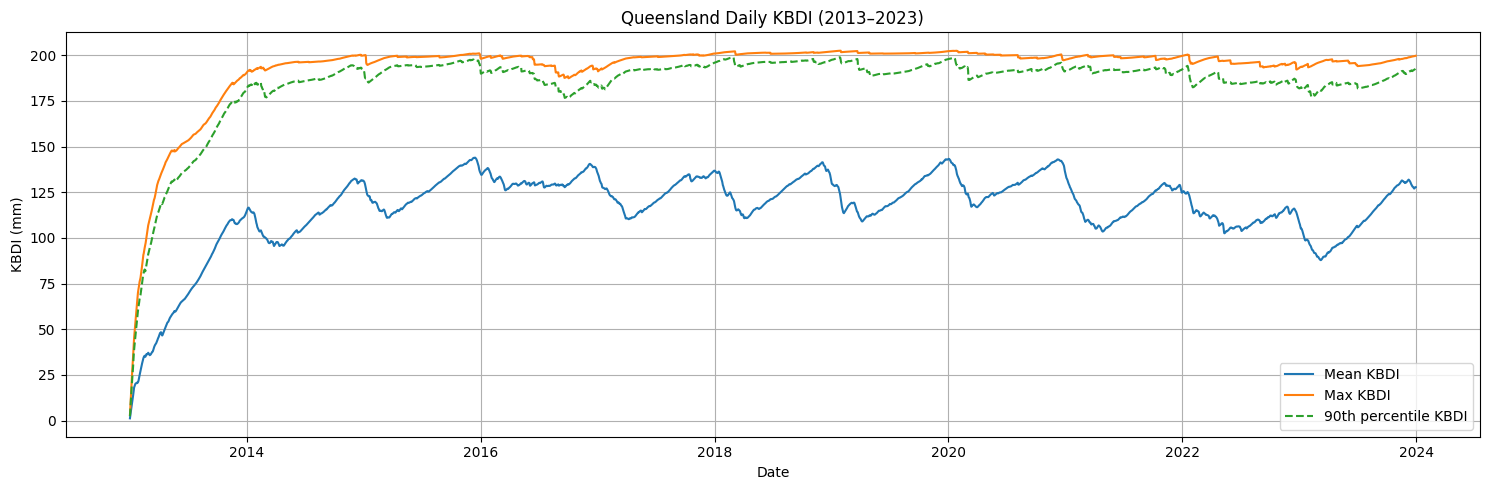

In [8]:
import matplotlib.pyplot as plt

# ------------------------------------------
# 1️⃣ Define paths and years
# ------------------------------------------
KBDI_DIR = Path("Outputs/KBDI_Output")
START_YEAR = 2013
END_YEAR = 2023

kbdi_list = []

# ------------------------------------------
# 2️⃣ Load all yearly KBDI files
# ------------------------------------------
for year in range(START_YEAR, END_YEAR + 1):
    kbdi_file = KBDI_DIR / f"KBDI_Queensland_{year}.nc"
    ds = xr.open_dataset(kbdi_file)
    kbdi = ds["KBDI"]
    kbdi_list.append(kbdi)

# Combine all years along time
kbdi_all = xr.concat(kbdi_list, dim="valid_time")

# ------------------------------------------
# 3️⃣ Compute spatial summaries
# ------------------------------------------
# Mean over pixels
kbdi_mean = kbdi_all.mean(dim=("latitude", "longitude"))
# Max over pixels
kbdi_max = kbdi_all.max(dim=("latitude", "longitude"))
# 90th percentile over pixels
kbdi_p90 = kbdi_all.quantile(0.9, dim=("latitude", "longitude"))

# ------------------------------------------
# 4️⃣ Plot
# ------------------------------------------
plt.figure(figsize=(15,5))
plt.plot(kbdi_all.valid_time, kbdi_mean, label="Mean KBDI")
plt.plot(kbdi_all.valid_time, kbdi_max, label="Max KBDI")
plt.plot(kbdi_all.valid_time, kbdi_p90, label="90th percentile KBDI", linestyle="--")
plt.title("Queensland Daily KBDI (2013–2023)")
plt.xlabel("Date")
plt.ylabel("KBDI (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
